<center><h1><a href='https://www.dathena.io/'>Dathena Hands-on NLP Technical Exercise</a></h1></center>
<br/>
<center><h4>By: Ahmed Amine MAJDOUBI</h4></center>

# Introduction

This notebook covers the necessary documentation and an explanation of my approach to my submission for the NLP excercise. The goal of my submission was not to produce the best accuracy or implement complex NLP algorithms, but rather to show that my ability in writing a clear, robust and well documented code for data science related tasks. At the end of the notebook, I will discuss what could be done to further improve the segmentation task.

The code in the notebook is divided into four main parts:
- <b>Document Extraction:</b> generate random articles of different languages from Wikipedia.
- <b>Language Detection:</b> detect the languages on the extracted documents, and group them by their language.
- <b>Text Processing:</b> process each document by tokenizing, stemming and removing stop words.
- <b>Document Clustering:</b> cluster each language group of document using TF-IDF and K-MEANS.

For this submission, I used the following third party libraries:
- <a href ='https://pypi.org/project/wikipedia/'>wikipedia</a>: Wikipedia API for python to access and parse data from Wikipedia.
- <a href ='https://pypi.org/project/langdetect/'>langdetect</a>: Language detection library ported from Google's language-detection. Supports 55 languages.
- <a href ='https://www.nltk.org/'>nltk</a>: Provides the necessary tools for symbolic and statistical natural language processing.

You can install these libraries using pip by uncommenting the following code:

In [ ]:
#!pip install wikipedia
#!pip install langdetect
#!pip install nltk

This notebook is fully automated and all the functions are flexible, meaning that you can try any combination by only changing the next block of code, and you are all set. The parameters of the code are:
- <b>languages:</b> list of the languages of the randomly generated articles. 
- <b>lang_dict:</b> dictionnary of the language codes and the full name of the languages (necessary for NLTK library).
- <b>articles_per_lang:</b> number of documents to generate per language.
- <b>nclusters:</b> number of clusters to generate for each language group.

In [1]:
# list of the languages of the randomly generated articles
languages = ["en", "fr", "es"]

# dictionnary of the language codes and the full name of the languages
lang_dict = dict({'fr':'french', 'en': 'english', 'es':'spanish'})

# number of documents to generate per language
articles_per_lang = 100

# number of clusters to generate for each language group
nclusters = dict({'fr':3, 'en': 3, 'es':3})

# number of keywords per cluster
n_terms = 7

In this notebook, we will be generating 300 random Wikipedia articles in English, French and Spanish languages. And will generate 3 clusters per language group. The <b>'nclusters'</b> parameter can be later changed just after looking at the results of the elbow method generated with my function <b>optimal_clusters()</b>.

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Text processing
import wikipedia
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from langdetect import detect

# Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Document Extraction

We will be using the <a href="https://github.com/goldsmith/Wikipedia">Wikipedia API in Python</a> to extract random articles of different languages. The articles are shuffled in order to not have any direct way of knowing the languages.

In [3]:
def random_articles(languages, articles_per_lang):
    """
    Extract random articles from Wikepedia.
    Returns a shuffled list of articles of different languages
    
    Arguments:
    * languages: a list of languages of the documents
    * articles_per_lang: number of articles per language
    
    """
    articles = []
    
    for language in languages:
        wikipedia.set_lang(language)
        titles = wikipedia.random(pages = articles_per_lang*2)
        count = 0
        
        for title in titles:
            try:
                article = wikipedia.page(title=title, auto_suggest='True', redirect=True).content
            except:
                pass
            articles.append(article)
            count += 1
            if count >= articles_per_lang:
                break
    
    random.shuffle(articles)
    return articles

%time articles = random_articles(languages, articles_per_lang)
print('Total number of articles:', len(articles))

CPU times: user 23.4 s, sys: 1.3 s, total: 24.7 s
Wall time: 4min 52s
Total number of articles: 300


It took us a very long time (5 mins) to exctract only 300 documents from Wikipedia. Keep that in mind when playing with the parameter <b>'articles_per_lang'</b>.

# Language Detection

We will be using the <a href = 'https://pypi.org/project/langdetect/'>langdetect</a> library to detect the language of each article. The results is a dictionnary containing languages as keys, and lists of articles as values. The results are not perfect, so we will be removing language keys with few articles in them (wrong detection).

In [5]:
def detect_language(articles, n_lang):
    '''
    Detects the language of the articles
    Returns a dictionnary of list of articles per language
    Argument:
    * articles: list of articles
    '''
    
    articles_dict = dict()
    for article in articles:
        lang = detect(article)
        if lang not in articles_dict.keys():
            articles_dict[lang] = []
        articles_dict[lang].append(article)

    # delete language keys with less than half of expected number of articles (probably incorrect language detection)
    for lang in list(articles_dict):
        if len(articles_dict[lang]) < len(articles)/(n_lang*4):
            articles_dict.pop(lang)
    
    return articles_dict

articles_dict = detect_language(articles, len(languages))

for lang in articles_dict.keys():
    print("language: ",lang,", N° documents:", len(articles_dict[lang]),", Avg document length",
          int(np.mean([len(article) for article in articles_dict[lang]])))

language:  fr , N° documents: 98 , Avg document length 3369
language:  en , N° documents: 103 , Avg document length 3065
language:  es , N° documents: 98 , Avg document length 3511


We see that the translation results are not perfect since we are not getting 100 articles per language. We also see that english articles are shorter on average compared to articles in other languages, but that could be just do to luck, since we are randomly generating the articles.

Min article length:  97
Max article length:  34414
Mean article length:  3311
Median article length:  1685


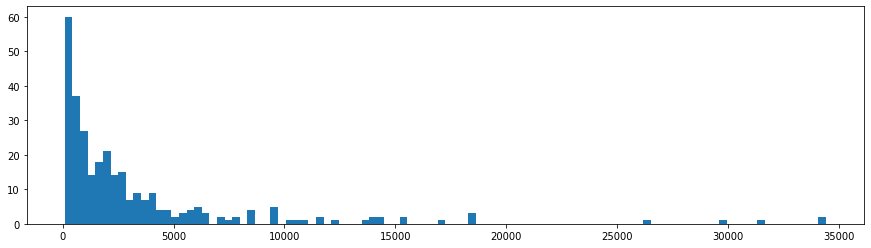

In [6]:
lengths = [len(article) for articles in articles_dict.values() for article in articles]
print('Min article length: ', np.min(lengths))
print('Max article length: ', np.max(lengths))
print('Mean article length: ', int(np.mean(lengths)))
print('Median article length: ', int(np.median(lengths)))

plt.figure(figsize=(15,4))
plt.hist(lengths, bins=100)
plt.show()

We also see that the generated Wikipedia documents vary a lot in size, ranging from 97 letters, to almost 35000.

# Text Processing 

This next function converts an article of sepcific language to a list of tokens of words. In our case, the text processing was done in 3 steps:
- First tokenize the text by sentence, then by word to ensure that punctuation is caught as it's own token.
- Filter out any tokens not containing letters.
- Perform stemming of the tokens.
- Remove the stop words from the tokens.

In [7]:
def process_article(article, lang):
    '''
    Process article by language
    Returns: list of tokens
    
    Parameters:
    * article: article to process (String)
    * lang: language
    
    '''
    stopwords = nltk.corpus.stopwords.words(lang_dict[lang])
    stemmer = SnowballStemmer(lang_dict[lang])
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(article) for word in nltk.word_tokenize(sent)]
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    # stem the words
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    # remove stopwords
    final_tokens = [token for token in stems if token not in stopwords]
    return final_tokens


tokens_dict = {}

for lang in articles_dict.keys():
    articles = []
    for article in articles_dict[lang]:
        articles.append(process_article(article, lang))
    tokens_dict[lang] = articles

# Document Clustering

In order to measure the documents similarity, we will be using the term frequency-inverse document frequency vectorizer (TF-IDF). This resulting weight matrix will be a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

To do this, we will be using the <b><a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a></b> class from scikit-learn, and we will be setting three parameters:
- min_df: the minimum percentage of documents the term would have to be in at least in order to be considered.
- max_df: the maximum percentage of documents the term would have to be in at most in order to be considered.
- ngram_range: the model would take into consideration the unigrams, the bigrams, as well as trigrams.

In [8]:
def tfidf_features(articles):
    '''
    Get the tf-idf matrix for the articles
    Returns: tf_idf matrix
    
    Parameters:
    * articles: list of tokenized articles
    '''
    
    articles = [' '.join(article) for article in articles]
    tfidf_vectorizer = TfidfVectorizer(min_df=0.15, max_df=0.8, ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(articles)
    tfidf_labels = tfidf_vectorizer.get_feature_names()
    return tfidf_matrix, tfidf_labels

tfidf_articles = {}
tfidf_labels = {}

for lang in articles_dict.keys():
    tfidf_articles[lang], tfidf_labels[lang] = tfidf_features(tokens_dict[lang])
    print(lang_dict[lang],' features: ', tfidf_articles[lang].shape)

french  features:  (98, 159)
english  features:  (103, 78)
spanish  features:  (98, 160)


We observe that we have half number of features in the english articles than on the other languages. This means that a huge chunk of words in the english vocabulary either appear rarely on articles, or appear on almost on all of the articles.

The next function plots the inertia (within-cluster sum-of-squares criterion) by number of clusters chosen. We will try to use the elbow method in order to determine which number of clusters is optimal for our problem.

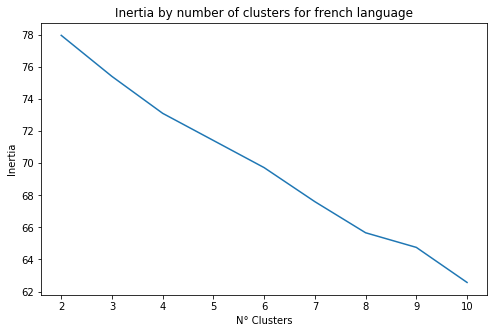

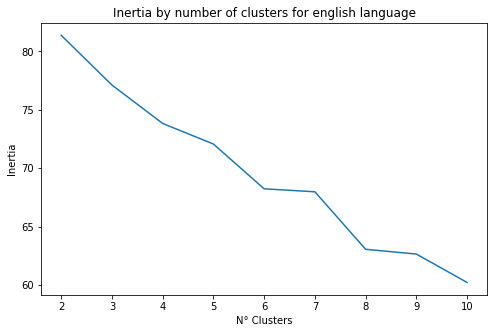

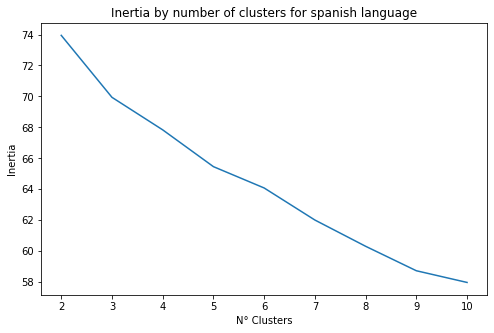

In [9]:
def optimal_clusters(articles, lang, max_nclusters=10):
    '''
    Find the optimal number of clusters by using the elbow method
    
    Parameters:
    * articles: list of Strings
    * max_nclusters: max number of cluster to try 
    '''
    
    # Calculate the intertia for each number of clusters
    results = []
    for i in range(2, max_nclusters+1):
        results.append(KMeans(n_clusters=i).fit(articles).inertia_)
    
    # Plot the results
    f, ax = plt.subplots(1, 1, figsize = (8,5))
    ax.plot(range(2, max_nclusters+1), results)
    ax.set_xlabel('N° Clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('Inertia by number of clusters for '+lang_dict[lang]+' language')
    
for lang in articles_dict.keys():
    optimal_clusters(tfidf_articles[lang], lang, 10)

We don't really see a clear elbow in the spansih and french groups plots. However, by looking at the english group plot, we can say that the optimal number of clusters is either 4 or 6.

We will be choosing 4 clusters for the french and english articles and 3 clusters for the spanish articles. 

In [10]:
nclusters = dict({'fr':4, 'en': 4, 'es':3})

def cluster_documents(articles, n_clusters=3):
    '''
    Perform a K-means clustering of the algorithms
    Returns: a list of cluster numbers
    
    Parameters:
    articles: list of Strings
    n_clusters: number of cluster to find 
    '''
    
    # Generate the clusters
    model = KMeans(n_clusters=n_clusters)
    clusters = model.fit(articles).labels_.tolist()
    
    return clusters

labels = {}
for lang in articles_dict.keys():
    labels[lang] = cluster_documents(tfidf_articles[lang], nclusters[lang])

for lang in labels.keys():
    print('\n',lang_dict[lang], 'group:')
    for cluster in Counter(labels[lang]).keys():
        print('cluster',cluster,': ',Counter(labels[lang])[cluster],'articles')


 french group:
cluster 2 :  27 articles
cluster 3 :  27 articles
cluster 0 :  32 articles
cluster 1 :  12 articles

 english group:
cluster 3 :  18 articles
cluster 2 :  23 articles
cluster 0 :  10 articles
cluster 1 :  52 articles

 spanish group:
cluster 2 :  44 articles
cluster 0 :  35 articles
cluster 1 :  19 articles


# Visualising Results

## 2D plot of clusters

The next function reduces the dimension of our data to 2 using PCA algorithm. Basically, these 2 new features explain the most amount of variance of our model. Then we will plot the 2D graph for each language group.

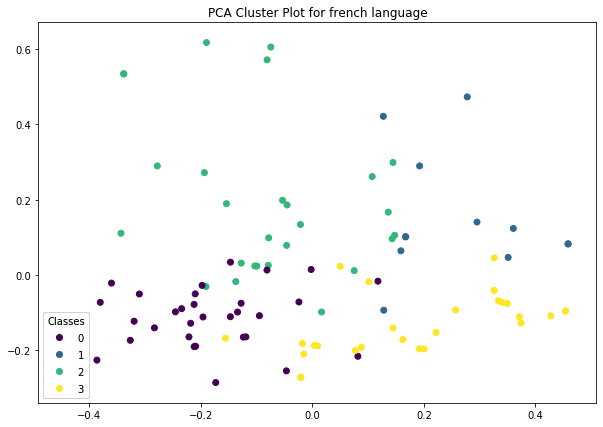

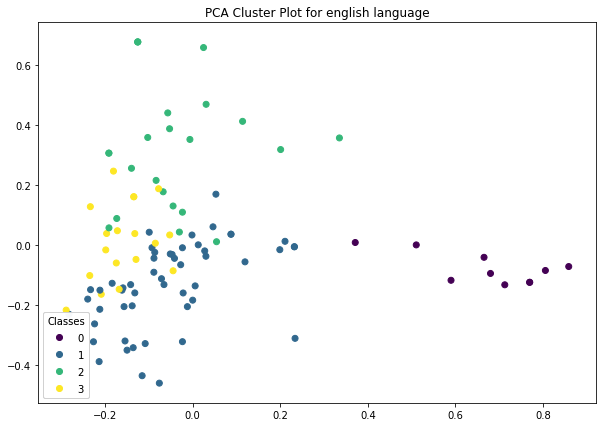

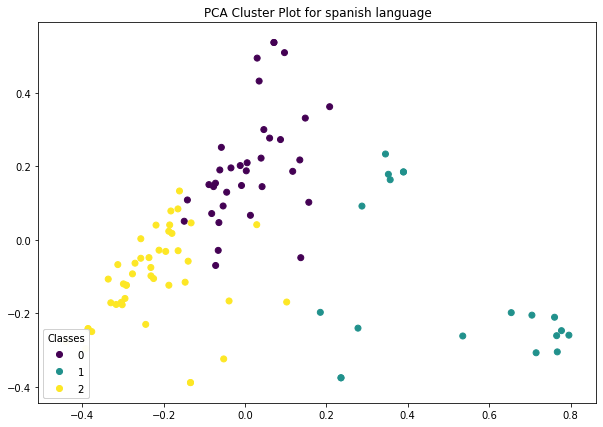

In [11]:
def plot_clusters(features, labels, lang):
    '''
    Plot the clusters generated by our Kmeans algorithm
    
    Parameters:
    * features: tfidf features of articles
    * labels: cluster labels for each article
    '''
    
    pca = PCA(n_components=2).fit_transform(features)
    
    f, ax = plt.subplots(1, 1, figsize = (10, 7))
    scatter = ax.scatter(pca[:, 0], pca[:, 1], c=labels)
    legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend)
    ax.set_title('PCA Cluster Plot for '+lang_dict[lang]+' language')


for lang in articles_dict.keys():
    plot_clusters(tfidf_articles[lang].toarray(), labels[lang], lang)    

The most seperated clusters are those of the spanish articles group, follow by english group and then french group.

The next function gets the top 7 keywords per cluster, for each cluster in the 3 language groups. the number 7 can be changed to whatever you want in the code.

## Top keywords per cluster

In [12]:
def top_keywords_per_cluster(features, cluster_labels, tfidf_labels, n_terms=10):
    '''
    Get top keywords per cluster
    Returns a list of lists of top keywords per cluster
    
    Parameters:
    * features: tfidf features of articles
    * cluster_labels: cluster labels for each article
    * tfidf_labels: tfidf feature names
    * n_terms: number of keywords per cluster
    '''
    
    df_keywords = pd.DataFrame(features)
    df_keywords['labels'] = cluster_labels
    keywords = []
    for index, row in df_keywords.groupby('labels').mean().iterrows():
        keywords.append([tfidf_labels[t] for t in np.argsort(row)[-n_terms:]])
    
    return keywords

top_keywords = {}

for lang in articles_dict.keys():
    top_keywords[lang] = top_keywords_per_cluster(tfidf_articles[lang].toarray(), 
                                                  labels[lang], tfidf_labels[lang], n_terms)

for lang in top_keywords.keys():
    print('\n',lang_dict[lang],'language')
    for i in range(len(top_keywords[lang])):
        keywords = ', '.join(top_keywords[lang][i])
        print('Cluster',i,':',keywords)


 french language
Cluster 0 : premi, qu, plus, franc, un, ser, dan
Cluster 1 : not référent, état, référent, dan, sud, not référent portail, référent portail
Cluster 2 : dan, national, vill, franc, histor, saint, commun
Cluster 3 : anglais, lien extern, extern, lien, dan, référent, articl

 english language
Cluster 0 : record, part, august, histori, world, found, famili
Cluster 1 : group, year, west, one, univers, new, work
Cluster 2 : product, locat, refer extern link, refer extern, link, extern, extern link
Cluster 3 : first, base, made, featur, record, use, releas

 spanish language
Cluster 0 : ciud, unid, equip, com, referent, internacional, famili
Cluster 1 : multimedi, multimedi sobr, commons alberg categor, region, ubic, habit, poblacion
Cluster 2 : tod, form, mas, part, tambien, par, com


Finally, let's calculate the silhouette score of the 3 cluster groups.  Basically, the silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

## Clustering silhouette score

In [13]:
for lang in tfidf_articles.keys():
    print(lang_dict[lang],'articles clustering score', 
          round(silhouette_score(tfidf_articles[lang], labels[lang]),2))

french articles clustering score 0.04
english articles clustering score 0.07
spanish articles clustering score 0.08


We See that the silhouette score is relatively low for all 3 cluster groups. This is probabably due to the fact that we extract articles randomly from Wikipedia, which means that there is hardly any relation between the articles within a language group.

# Conclusion

This notebook is a sort of a beginner blueprint to clusterize documents. If you want to use your own documents, you just have to ignore the <b>'random_articles()'</b> function and put your documents in a list called <b>articles</b>.

If we want to go further and improve our segmentation, we could replace TF-IDF features by LDA or LSA features. Latent Dirichlet Allocation (LDA) is a sort of probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. Also LDA is more flexible than methods likde LSA (Latent Semantic Analysis) because of having Alpha and Beta vectors that can adjust to the contribution of each topic in a document and word in a topic. It can help if the documents are not of similar length or quality (our case).

We could also use Glove and Word2vec features, which are both unsupervised models for generating word vectors (the difference between them is in the mechanism of generating these vectors). We could use a pretrained model to generate the vectors of words or train on our corpus directly, altough I do not advise the latter, since we wouldn't have enough documents for the training.

Moreover, we could add a dimentionality reduction part between creating features and clustering. We could use a simple model like PCA, Kernel PCA, ICA, t-SNE or UMAP. We could also try a different clustering algorithm like Mean-Shift Clustering, DBSCAN or Hierarchical clustering.